In [1]:
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# 将 Projection 目录加入路径，以便导入 rellis_utils
# 假设当前 notebook 在 notebbooks/ 目录下，而 Projection 在上级目录
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "Projection"))
if project_root not in sys.path:
    sys.path.append(project_root)

# 导入现有的工具函数
try:
    from rellis_utils.lidar2img import load_from_bin, get_cam_mtx, get_mtx_from_yaml, points_filter
    print("成功导入 rellis_utils")
except ImportError as e:
    print(f"导入失败: {e}")
    print(f"请检查路径是否正确: {project_root}")

# 设置 matplotlib 显示参数
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

成功导入 rellis_utils


In [2]:
import os
import glob

# ================= 配置区域 =================
# 1. Rellis-3D 数据集根目录
RELLIS_ROOT = '/home/xzy/datasets/Rellis-3D'

# 2. 推理结果目录
INFERENCE_DIR = '/home/xzy/Downloads/convertedRellis/rellisv3_edl_train-4/01_inferenced_npy'

# 3. 选择序列和帧号
SEQ_ID = '00004' 
FRAME_ID = '000000' 

# 4. 畸变系数，从原项目读取
dist_coeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0]).reshape((5,1)) # Rellis 参数

# ================= 自动生成文件路径 =================

# --- 1. 图像路径 (使用 glob 匹配时间戳) ---
img_pattern = os.path.join(RELLIS_ROOT, SEQ_ID, 'pylon_camera_node', f"frame{FRAME_ID}-*.jpg")
img_files = glob.glob(img_pattern)

if len(img_files) > 0:
    img_file = img_files[0]
else:
    print(f"警告: 未找到图像文件: {img_pattern}")
    img_file = None

# --- 2. LiDAR 点云路径 ---
# Rellis 的 bin 文件通常没有时间戳后缀，直接是 000000.bin
lidar_file = os.path.join(RELLIS_ROOT, SEQ_ID, 'os1_cloud_node_kitti_bin', f"{FRAME_ID}.bin")

# --- 3. 语义预测结果 (.npy) ---
npy_pattern = os.path.join(INFERENCE_DIR, SEQ_ID, f"frame{FRAME_ID}-*.npy")
npy_files = glob.glob(npy_pattern)

if len(npy_files) > 0:
    prob_map_file = npy_files[0]
else:
    print(f"警告: 未找到图像文件: {npy_pattern}")
    prob_map_file = None

# --- 4. 标定文件路径 ---
camera_info_file = os.path.join(RELLIS_ROOT, 'Rellis_3D_cam_intrinsic', 'Rellis-3D', SEQ_ID, 'camera_info.txt')
if not os.path.exists(camera_info_file):
    camera_info_file = os.path.join(RELLIS_ROOT, SEQ_ID, 'camera_info.txt')

transforms_file = os.path.join(RELLIS_ROOT, 'Rellis_3D_cam2lidar_20210224', 'Rellis_3D', SEQ_ID, 'transforms.yaml')
if not os.path.exists(transforms_file):
    transforms_file = os.path.join(RELLIS_ROOT, SEQ_ID, 'transforms.yaml')

# ================= 验证输出 =================
print(f"当前测试序列: {SEQ_ID}, 帧号: {FRAME_ID}")
print("-" * 30)

# 检查图像
if img_file and os.path.exists(img_file):
    print(f"[OK] Image File: {img_file}")
else:
    print(f"[ERROR] Image File Not Found (Pattern: {img_pattern})")

# 检查 LiDAR
if os.path.exists(lidar_file):
    print(f"[OK] LiDAR File: {lidar_file}")
else:
    print(f"[ERROR] LiDAR File Not Found: {lidar_file}")

# 检查 NPY
if prob_map_file and os.path.exists(prob_map_file):
    print(f"[OK] Prob Map File: {prob_map_file}")
else:
    print(f"[ERROR] Prob Map File Not Found (Pattern: {npy_pattern})")

# 检查标定
print(f"[{'OK' if os.path.exists(camera_info_file) else 'ERROR'}] Camera Info: {camera_info_file}")
print(f"[{'OK' if os.path.exists(transforms_file) else 'ERROR'}] Transforms: {transforms_file}")

当前测试序列: 00004, 帧号: 000000
------------------------------
[OK] Image File: /home/xzy/datasets/Rellis-3D/00004/pylon_camera_node/frame000000-1581791678_408.jpg
[OK] LiDAR File: /home/xzy/datasets/Rellis-3D/00004/os1_cloud_node_kitti_bin/000000.bin
[OK] Prob Map File: /home/xzy/Downloads/convertedRellis/rellisv3_edl_train-4/01_inferenced_npy/00004/frame000000-1581791678_408.npy
[OK] Camera Info: /home/xzy/datasets/Rellis-3D/Rellis_3D_cam_intrinsic/Rellis-3D/00004/camera_info.txt
[OK] Transforms: /home/xzy/datasets/Rellis-3D/Rellis_3D_cam2lidar_20210224/Rellis_3D/00004/transforms.yaml


In [3]:
def project_and_filter(lidar_points, P, RT_os1_to_cam, dist_coeff, img_size):
    """
    投影点云并进行简单的视锥过滤
    final_img_points 像素位置 (u, v)
    final_cam_points 相机系坐标 (x, y, z)
    final_raw_points 雷达系坐标 (x, y, z)
    		
    """
    h, w = img_size
    
    # 1. 坐标转换与视锥过滤 (使用 rellis_utils 中的函数)
    # points_filter 返回的是过滤后的点 (N, 3) 和颜色 (N,)，我们只需要点
    # 注意：points_filter 内部其实已经做了一部分 RT 变换，我们需要确认它的输出是在哪个坐标系
    # 查看 lidar2img.py: p_c = np.matmul(ctl, p_l.T) -> 转换到了相机坐标系
    
    # 手动分步执行以获得更精确的控制
    # A. 转换到相机坐标系
    R_vc = RT_os1_to_cam[:3, :3]
    T_vc = RT_os1_to_cam[:3, 3].reshape(3, 1)
    
    # 原始点云 (N, 3)
    xyz_h = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1)))) # Homogeneous
    xyz_cam = (RT_os1_to_cam @ xyz_h.T).T # (N, 4)
    xyz_cam = xyz_cam[:, :3] # (N, 3) in Camera Frame
    
    # B. 剔除 Z < 0 的点 (相机后方)
    mask_z = xyz_cam[:, 2] > 0.1
    xyz_cam = xyz_cam[mask_z]
    lidar_points_filtered = lidar_points[mask_z] # 对应的原始点云
    
    # C. 投影到像素平面
    # cv2.projectPoints 需要旋转和平移向量，因为我们已经转换到了相机坐标系，
    # 所以这里的 rvec, tvec应该是 0 (Identity transform)
    rvec_identity = np.zeros((3, 1))
    tvec_identity = np.zeros((3, 1))
    
    img_points, _ = cv2.projectPoints(xyz_cam, rvec_identity, tvec_identity, P, dist_coeff)
    img_points = img_points.squeeze() # (N, 2)
    
    # D. 剔除图像范围外的点
    u = img_points[:, 0]
    v = img_points[:, 1]
    mask_uv = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    
    final_img_points = img_points[mask_uv]
    final_cam_points = xyz_cam[mask_uv] # 包含深度信息 Z
    final_raw_points = lidar_points_filtered[mask_uv]
    
    return final_img_points, final_cam_points, final_raw_points

def handle_occlusion(img_points, cam_points, raw_points, img_size):
    """
    核心改进：Z-buffer 遮挡剔除
    如果多个点投影到同一个像素，只保留深度最小的那个。
    """
    h, w = img_size
    u = np.round(img_points[:, 0]).astype(int)
    v = np.round(img_points[:, 1]).astype(int)
    depth = cam_points[:, 2] # Z 轴为深度
    
    # 1. 按深度排序 (从小到大)
    sort_idx = np.argsort(depth)
    u_sorted = u[sort_idx]
    v_sorted = v[sort_idx]
    
    # 2. 利用 np.unique 的特性找到每个 (v, u) 组合出现的第一个索引
    # 因为已经按深度排序，第一个出现的就是深度最小的
    # 将 2D 坐标扁平化为 1D 索引: idx = v * width + u
    flat_pixel_indices = v_sorted * w + u_sorted
    _, unique_indices = np.unique(flat_pixel_indices, return_index=True)
    
    # unique_indices 是在 sort_idx 里的下标
    best_indices_in_sorted = unique_indices
    
    # 映射回原始数组的下标
    final_indices = sort_idx[best_indices_in_sorted]
    
    return np.arange(len(img_points))

In [8]:
H_ORIG, W_ORIG = 1200, 1920  # 原始分辨率
SCALE_FACTOR = 0.5           # 降采样倍率
H_LOW, W_LOW = int(H_ORIG * SCALE_FACTOR), int(W_ORIG * SCALE_FACTOR) # 600, 960

# 1. 加载数据
P = get_cam_mtx(camera_info_file)
RT_os1_to_cam = get_mtx_from_yaml(transforms_file)

# 加载点云
os1_points = load_from_bin(lidar_file)
print(f"原始点云数量: {os1_points.shape}")

# 加载概率图
prob_map = np.load(prob_map_file) # (C, H, W) 或 (H, W) 取决于你的保存方式
# 如果是 (C, H, W)，我们需要转置或者注意索引顺序
print(f"概率图形状: {prob_map.shape}")
C, H, W = prob_map.shape 

# 2. 投影
img_pts, cam_pts, raw_pts = project_and_filter(os1_points, P, RT_os1_to_cam, dist_coeff, (H*2, W*2))
print(f"视锥过滤后点云数量: {raw_pts.shape}")

# 3. 遮挡剔除 (关键步骤)
keep_indices = handle_occlusion(img_pts, cam_pts, raw_pts, (H, W))
valid_img_pts = img_pts[keep_indices]
valid_raw_pts = raw_pts[keep_indices]
print(f"遮挡剔除后点云数量: {valid_raw_pts.shape}")

# 4. 降采样
u_low = (valid_img_pts[:, 0] * 0.5).astype(int)
v_low = (valid_img_pts[:, 1] * 0.5).astype(int)

# 5. 边界安全检查 (防止 float 运算导致 960 变成 960.5 -> int 960 -> 越界)
u_valid = np.clip(u_low, 0, W_LOW - 1)
v_valid = np.clip(v_low, 0, H_LOW - 1)

# # 4. 采样概率
# # 最近邻采样
# u_valid = np.round(valid_img_pts[:, 0]).astype(int)
# v_valid = np.round(valid_img_pts[:, 1]).astype(int)

# # 强制限制索引在图像边界内 [0, W-1] 和 [0, H-1]
# u_valid = np.clip(u_valid, 0, W - 1)
# v_valid = np.clip(v_valid, 0, H - 1)

# 从概率图中取出对应像素的概率向量
# prob_map: (C, H, W) -> points_probs: (N, C)
points_probs = prob_map[:, v_valid, u_valid].T 

# 获取最大概率对应的类别 (Pred Labels)
points_labels = np.argmax(points_probs, axis=1)

print(f"采样完成，获得 {points_probs.shape[0]} 个点的语义信息")
print("valid_img_pts", valid_img_pts.shape)

原始点云数量: (131072, 3)
概率图形状: (9, 600, 960)
视锥过滤后点云数量: (5950, 3)
遮挡剔除后点云数量: (5950, 3)
采样完成，获得 5950 个点的语义信息
valid_img_pts (5950, 2)


正在调整图像尺寸: 原图 (1200, 1920) -> 目标 (600, 960)


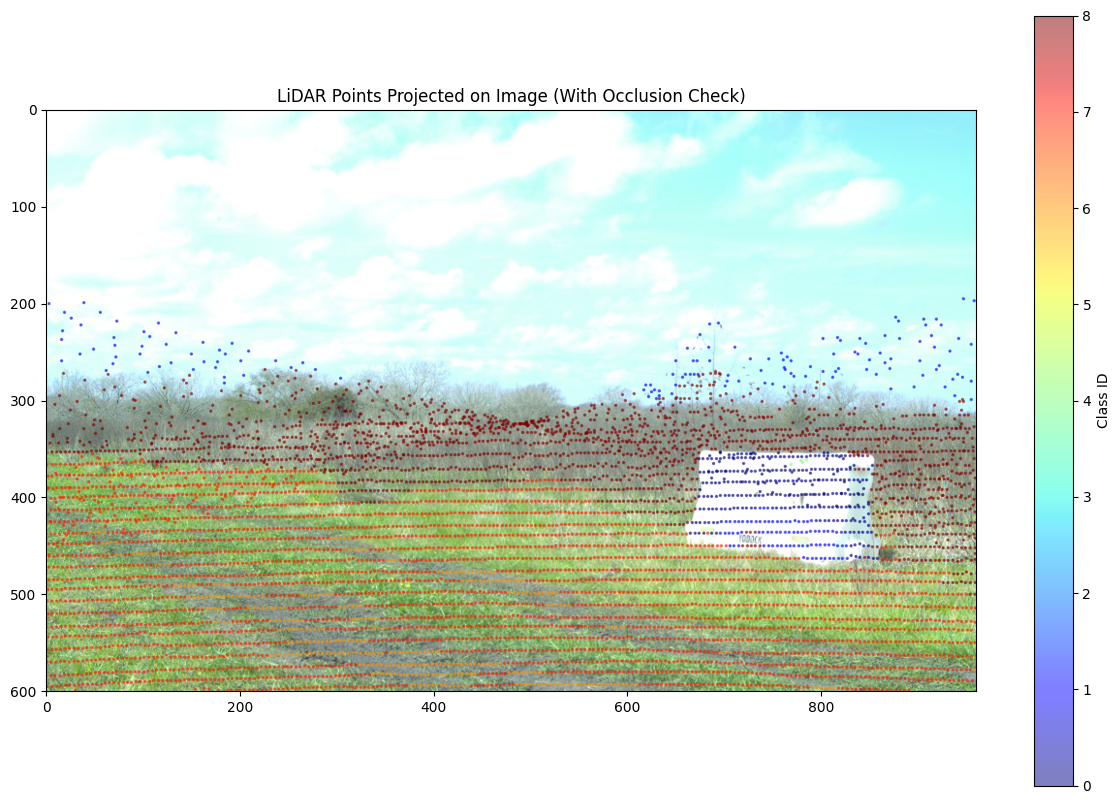

In [9]:
# 加载原始图像
if img_file and os.path.exists(img_file):
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image.shape[0] != H or image.shape[1] != W:
        print(f"正在调整图像尺寸: 原图 {image.shape[:2]} -> 目标 {(H, W)}")
        # cv2.resize 接受 (width, height)
        image = cv2.resize(image, (W, H), interpolation=cv2.INTER_LINEAR)
    
    plt.figure(figsize=(15, 10)) # 调整画布大小
    plt.imshow(image)
    
    
    # 绘制点云
    # 使用 points_labels 作为颜色映射
    # Rellis-3D 通常有 20 个类别，我们用 jet colormap
    sc = plt.scatter(u_valid, v_valid, c=points_labels, s=2, cmap='jet', alpha=0.5)
    plt.colorbar(sc, label='Class ID')
    plt.title("LiDAR Points Projected on Image (With Occlusion Check)")
    plt.xlim(0, W)
    plt.ylim(H, 0) # 图像坐标系 Y 轴向下
    plt.show()
else:
    print("未找到图像文件，无法进行叠加可视化。")